DeepLarning Couse HSE 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```,
* ```https://vk.com/ars.ashuha``` 
* partially reusing https://github.com/ebenolson/pydata2015

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [ ]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 15.8 s, sys: 19.5 s, total: 35.3 s
Wall time: 45.3 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)

In [5]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

#good old as_matrix for the third time
def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [8]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [9]:
import theano
import theano.tensor as T

In [10]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences,PAD_ix)

In [11]:
import lasagne
from lasagne.layers import *

In [12]:
#network inputs
l_words = InputLayer((None,None),sentences )
l_mask = InputLayer((None,None),sentence_mask)

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)

#cudos for using some pre-trained embedding :)

In [13]:
# input layer for image features
l_image_features = InputLayer((None,CNN_FEATURE_SIZE),image_vectors)

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None,LSTM_UNITS)

In [14]:
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)

#find out better recurrent architectures for bonus point

In [15]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder,(0,1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

broadcasted decoder shape =  (None, 200)


In [16]:
#predict probabilities for next tokens
predicted_probabilities_each_tick = DenseLayer(broadcast_decoder_ticks,n_tokens,
                                               nonlinearity=lasagne.nonlinearities.softmax)
# maybe a more complicated architecture will work better?

In [17]:
#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(predicted_probabilities_each_tick,
                                           broadcast_layer=broadcast_decoder_ticks)

print "output shape = ",predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

output shape =  (None, None, 10373)


### Some tricks
* If you train large network, it is usually a good idea to make a 2-stage prediction
    1. (large recurrent state) -> (bottleneck e.g. 256)
    2. (bottleneck) -> (vocabulary size)
    * this way you won't need to store/train (large_recurrent_state x vocabulary size) matrix
* Also maybe use Hierarchical Softmax?
    * https://gist.github.com/justheuristic/581853c6d6b87eae9669297c2fb1052d




In [18]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:,:-1].reshape((-1,n_tokens)),
    reference_answers.reshape((-1,))).reshape(reference_answers.shape)

#mean over non-PAD tokens
loss = (loss*output_mask).sum() / output_mask.sum()

In [19]:
#trainable NN weights
weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss,weights)

In [20]:
#compile a functions for training and evaluation
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)
#for val_step use deterministic=True if you have any dropout/noize

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [21]:
captions = np.array(captions)

In [22]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0,len(images),size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice,captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [23]:
generate_batch(img_codes,captions,3)

(array([[-5.48575354, -1.54412508,  1.41898394, ..., -1.78699064,
          0.37463304,  0.54959393],
        [-0.60422653, -4.40316391, -0.10351748, ...,  1.54852843,
          1.21479321, -0.25864881],
        [-3.00670767,  1.35014451, -2.99214602, ...,  0.47168773,
          3.79567528,  2.87423801]], dtype=float32),
 array([[ 8481,  8717,  3059,  1558,   781,  7130,  4859,  8717,  9527,
          4859,  9879,  8134,    -1],
        [ 8481,  8717,  8534,  3302, 10058,  8717,  9934,  5989,  8902,
          3980,  8717,  6708,  8134],
        [ 8481,  8717,  9934,  6397,   326,  8717,  1879, 10023,   781,
          3976,  8528,    81,  8134]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [24]:
batch_size=50 #adjust me
n_epochs=100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [25]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

100%|██████████| 50/50 [01:52<00:00,  2.13s/it]

Epoch: 0, train loss: 6.76766950258, val loss: 5.58600401531
Epoch: 1, train loss: 5.41015683035, val loss: 5.31067661051


100%|██████████| 50/50 [02:02<00:00,  2.75s/it]


Epoch: 2, train loss: 5.11185801771, val loss: 5.01954578631


100%|██████████| 50/50 [02:10<00:00,  2.53s/it]


Epoch: 3, train loss: 4.8685417716, val loss: 4.85334644481


100%|██████████| 50/50 [02:09<00:00,  2.20s/it]


Epoch: 4, train loss: 4.68556742821, val loss: 4.56415225736


100%|██████████| 50/50 [01:51<00:00,  2.28s/it]


Epoch: 5, train loss: 4.46887065481, val loss: 4.38021907187


100%|██████████| 50/50 [01:50<00:00,  2.55s/it]


Epoch: 6, train loss: 4.34640034547, val loss: 4.20856177189


100%|██████████| 50/50 [01:49<00:00,  2.15s/it]


Epoch: 7, train loss: 4.21585359146, val loss: 4.10602555879


100%|██████████| 50/50 [01:42<00:00,  1.80s/it]


Epoch: 8, train loss: 4.09116554364, val loss: 3.98739807064


100%|██████████| 50/50 [01:50<00:00,  2.13s/it]


Epoch: 9, train loss: 3.98769540371, val loss: 3.99461959027


100%|██████████| 50/50 [01:55<00:00,  2.22s/it]


Epoch: 10, train loss: 3.92042642138, val loss: 3.81645977602


100%|██████████| 50/50 [01:59<00:00,  1.91s/it]


Epoch: 11, train loss: 3.9134929355, val loss: 3.76069802772


100%|██████████| 50/50 [01:49<00:00,  2.24s/it]


Epoch: 12, train loss: 3.83999775105, val loss: 3.69115627193


100%|██████████| 50/50 [02:05<00:00,  1.95s/it]


Epoch: 13, train loss: 3.76529012057, val loss: 3.7038960004


100%|██████████| 50/50 [01:42<00:00,  2.03s/it]


Epoch: 14, train loss: 3.74142228027, val loss: 3.77863466674


100%|██████████| 50/50 [01:44<00:00,  2.12s/it]


Epoch: 15, train loss: 3.69715336455, val loss: 3.75087770502


100%|██████████| 50/50 [01:43<00:00,  2.02s/it]


Epoch: 16, train loss: 3.65209079061, val loss: 3.60371476057


100%|██████████| 50/50 [01:44<00:00,  2.11s/it]


Epoch: 17, train loss: 3.61345244334, val loss: 3.60769920044


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


Epoch: 18, train loss: 3.56929243422, val loss: 3.5741309719


100%|██████████| 50/50 [01:58<00:00,  7.41s/it]


Epoch: 19, train loss: 3.53406477751, val loss: 3.46789381422


100%|██████████| 50/50 [01:40<00:00,  1.86s/it]


Epoch: 20, train loss: 3.51912372474, val loss: 3.3300049551


100%|██████████| 50/50 [01:44<00:00,  2.19s/it]


Epoch: 21, train loss: 3.51245725365, val loss: 3.54178489961


100%|██████████| 50/50 [01:44<00:00,  1.96s/it]


Epoch: 22, train loss: 3.45676470733, val loss: 3.40196312605


100%|██████████| 50/50 [02:01<00:00,  2.53s/it]


Epoch: 23, train loss: 3.44425897023, val loss: 3.35866889384


100%|██████████| 50/50 [01:43<00:00,  1.91s/it]


Epoch: 24, train loss: 3.39221249605, val loss: 3.39798712314


100%|██████████| 50/50 [01:38<00:00,  1.74s/it]


Epoch: 25, train loss: 3.37150710128, val loss: 3.36585629844


100%|██████████| 50/50 [01:36<00:00,  1.98s/it]


Epoch: 26, train loss: 3.43173376354, val loss: 3.39149220259


100%|██████████| 50/50 [01:40<00:00,  1.93s/it]


Epoch: 27, train loss: 3.36062656531, val loss: 3.33528517219


100%|██████████| 50/50 [01:32<00:00,  2.27s/it]


Epoch: 28, train loss: 3.31330797922, val loss: 3.35353911388


100%|██████████| 50/50 [01:33<00:00,  1.97s/it]


Epoch: 29, train loss: 3.31929028656, val loss: 3.3189361607


100%|██████████| 50/50 [01:39<00:00,  1.87s/it]


Epoch: 30, train loss: 3.31802761666, val loss: 3.28201430171


100%|██████████| 50/50 [01:40<00:00,  1.92s/it]


Epoch: 31, train loss: 3.26761480654, val loss: 3.36316825833


100%|██████████| 50/50 [01:50<00:00,  2.05s/it]


Epoch: 32, train loss: 3.24927302872, val loss: 3.30937204577


100%|██████████| 50/50 [01:40<00:00,  2.15s/it]


Epoch: 33, train loss: 3.2696061355, val loss: 3.23968942472


100%|██████████| 50/50 [01:41<00:00,  1.80s/it]


Epoch: 34, train loss: 3.25568453074, val loss: 3.04002241935


100%|██████████| 50/50 [01:38<00:00,  1.96s/it]


Epoch: 35, train loss: 3.23878368619, val loss: 3.28156085824


100%|██████████| 50/50 [01:38<00:00,  1.85s/it]


Epoch: 36, train loss: 3.23183430044, val loss: 3.12093977179


100%|██████████| 50/50 [01:37<00:00,  2.01s/it]


Epoch: 37, train loss: 3.19582280663, val loss: 3.09644473491


100%|██████████| 50/50 [01:44<00:00,  2.62s/it]


Epoch: 38, train loss: 3.20383490668, val loss: 3.14519485457


100%|██████████| 50/50 [01:37<00:00,  2.00s/it]


Epoch: 39, train loss: 3.15545332396, val loss: 3.07996007395


100%|██████████| 50/50 [01:46<00:00,  1.83s/it]


Epoch: 40, train loss: 3.18284991133, val loss: 3.2339418008


100%|██████████| 50/50 [01:35<00:00,  1.87s/it]


Epoch: 41, train loss: 3.13288513427, val loss: 3.22448440207


100%|██████████| 50/50 [02:03<00:00,  2.21s/it]


Epoch: 42, train loss: 3.1715653871, val loss: 3.02687047586


100%|██████████| 50/50 [01:44<00:00,  2.07s/it]


Epoch: 43, train loss: 3.14011192327, val loss: 3.09753058715


100%|██████████| 50/50 [01:41<00:00,  2.17s/it]


Epoch: 44, train loss: 3.16421429519, val loss: 3.19667771334


100%|██████████| 50/50 [01:52<00:00,  2.17s/it]


Epoch: 45, train loss: 3.11186008023, val loss: 3.0309902789


100%|██████████| 50/50 [01:35<00:00,  1.80s/it]


Epoch: 46, train loss: 3.11237146123, val loss: 3.06114425649


100%|██████████| 50/50 [01:36<00:00,  1.74s/it]


Epoch: 47, train loss: 3.10532420684, val loss: 3.10466133399


100%|██████████| 50/50 [01:30<00:00,  1.77s/it]


Epoch: 48, train loss: 3.0635369022, val loss: 3.0528243142


100%|██████████| 50/50 [01:43<00:00,  1.98s/it]


Epoch: 49, train loss: 3.09589428548, val loss: 3.15803874252


100%|██████████| 50/50 [01:38<00:00,  1.99s/it]


Epoch: 50, train loss: 3.06110493498, val loss: 2.98771999263


100%|██████████| 50/50 [01:37<00:00,  1.78s/it]


Epoch: 51, train loss: 3.06397870579, val loss: 3.05121691178


100%|██████████| 50/50 [02:06<00:00,  2.42s/it]


Epoch: 52, train loss: 3.06234693261, val loss: 3.21385757245


100%|██████████| 50/50 [01:42<00:00,  1.89s/it]


Epoch: 53, train loss: 3.06222329797, val loss: 2.95182124982


100%|██████████| 50/50 [01:41<00:00,  2.15s/it]


Epoch: 54, train loss: 3.04632570029, val loss: 3.09944421181


100%|██████████| 50/50 [01:50<00:00,  1.82s/it]


Epoch: 55, train loss: 3.03804173226, val loss: 3.02546808132


100%|██████████| 50/50 [01:36<00:00,  1.62s/it]


Epoch: 56, train loss: 3.02038210936, val loss: 3.04648388874


100%|██████████| 50/50 [02:00<00:00,  2.15s/it]


Epoch: 57, train loss: 3.05002137789, val loss: 3.19644811489


100%|██████████| 50/50 [01:43<00:00,  1.91s/it]


Epoch: 58, train loss: 3.02429075987, val loss: 2.9053773447


100%|██████████| 50/50 [01:40<00:00,  1.95s/it]


Epoch: 59, train loss: 3.0631496214, val loss: 2.99483688544


100%|██████████| 50/50 [01:37<00:00,  1.78s/it]


Epoch: 60, train loss: 3.00557814221, val loss: 3.10661543569


100%|██████████| 50/50 [01:45<00:00,  2.19s/it]


Epoch: 61, train loss: 3.0068705521, val loss: 3.06032381254


100%|██████████| 50/50 [01:35<00:00,  1.69s/it]


Epoch: 62, train loss: 2.97815884752, val loss: 3.00073705466


100%|██████████| 50/50 [01:42<00:00,  1.87s/it]


Epoch: 63, train loss: 3.00854784821, val loss: 2.90645709716


100%|██████████| 50/50 [01:39<00:00,  2.65s/it]


Epoch: 64, train loss: 3.00752551539, val loss: 3.02784206211


100%|██████████| 50/50 [01:37<00:00,  2.03s/it]


Epoch: 65, train loss: 2.97040798548, val loss: 2.84203405614


100%|██████████| 50/50 [01:42<00:00,  1.82s/it]


Epoch: 66, train loss: 2.93027134851, val loss: 2.92553799684


100%|██████████| 50/50 [02:13<00:00,  2.16s/it]


Epoch: 67, train loss: 2.98882247667, val loss: 2.89211189001


100%|██████████| 50/50 [01:43<00:00,  1.99s/it]


Epoch: 68, train loss: 2.93130125598, val loss: 2.77894765639


100%|██████████| 50/50 [01:47<00:00,  2.04s/it]


Epoch: 69, train loss: 2.94062875141, val loss: 3.01595477362


100%|██████████| 50/50 [01:41<00:00,  2.02s/it]


Epoch: 70, train loss: 2.97199671972, val loss: 2.87929521477


100%|██████████| 50/50 [01:41<00:00,  2.35s/it]


Epoch: 71, train loss: 2.96871387253, val loss: 2.928122074


100%|██████████| 50/50 [01:44<00:00,  1.89s/it]


Epoch: 72, train loss: 2.95139955346, val loss: 2.90221902893


100%|██████████| 50/50 [01:45<00:00,  1.90s/it]


Epoch: 73, train loss: 2.93621369593, val loss: 2.96439925602


100%|██████████| 50/50 [01:41<00:00,  2.31s/it]


Epoch: 74, train loss: 2.91028465619, val loss: 2.94372268196


100%|██████████| 50/50 [01:39<00:00,  1.78s/it]


Epoch: 75, train loss: 2.93198796157, val loss: 2.91145176434


100%|██████████| 50/50 [01:44<00:00,  1.79s/it]


Epoch: 76, train loss: 2.92250403832, val loss: 2.86670543142


100%|██████████| 50/50 [01:37<00:00,  1.85s/it]


Epoch: 77, train loss: 2.93327401152, val loss: 2.88177872369


100%|██████████| 50/50 [01:45<00:00,  2.15s/it]


Epoch: 78, train loss: 2.88879899264, val loss: 2.92396469063


100%|██████████| 50/50 [01:41<00:00,  1.81s/it]


Epoch: 79, train loss: 2.9102536833, val loss: 2.93393490901


100%|██████████| 50/50 [01:37<00:00,  1.79s/it]


Epoch: 80, train loss: 2.97129593931, val loss: 2.96941124878


100%|██████████| 50/50 [01:39<00:00,  1.92s/it]


Epoch: 81, train loss: 2.88669393525, val loss: 2.90605611446


100%|██████████| 50/50 [01:33<00:00,  1.74s/it]


Epoch: 82, train loss: 2.91736553673, val loss: 2.9490812483


100%|██████████| 50/50 [01:57<00:00,  2.36s/it]


Epoch: 83, train loss: 2.89423756471, val loss: 2.88346709762


100%|██████████| 50/50 [01:36<00:00,  1.85s/it]


Epoch: 84, train loss: 2.88965357112, val loss: 2.88234738966


100%|██████████| 50/50 [01:40<00:00,  2.06s/it]


Epoch: 85, train loss: 2.86913810065, val loss: 2.86506389515


100%|██████████| 50/50 [01:57<00:00,  2.05s/it]


Epoch: 86, train loss: 2.90181950363, val loss: 2.98756996755


100%|██████████| 50/50 [01:37<00:00,  2.05s/it]


Epoch: 87, train loss: 2.90740959792, val loss: 2.76079344374


100%|██████████| 50/50 [01:52<00:00,  2.18s/it]


Epoch: 88, train loss: 2.88048328696, val loss: 2.80238211927


100%|██████████| 50/50 [01:42<00:00,  2.08s/it]


Epoch: 89, train loss: 2.8625951393, val loss: 2.90216671502


100%|██████████| 50/50 [01:38<00:00,  1.70s/it]


Epoch: 90, train loss: 2.83024751301, val loss: 2.88582646326


100%|██████████| 50/50 [01:39<00:00,  2.81s/it]


Epoch: 91, train loss: 2.85593426358, val loss: 2.87451025743


100%|██████████| 50/50 [01:36<00:00,  1.85s/it]


Epoch: 92, train loss: 2.82491550403, val loss: 2.83297182979


100%|██████████| 50/50 [02:13<00:00,  2.17s/it]


Epoch: 93, train loss: 2.86420637089, val loss: 2.821404613


100%|██████████| 50/50 [01:43<00:00,  2.05s/it]


Epoch: 94, train loss: 2.82384749697, val loss: 2.99966789735


100%|██████████| 50/50 [01:53<00:00,  2.00s/it]


Epoch: 95, train loss: 2.84132915556, val loss: 2.88999661546


100%|██████████| 50/50 [01:42<00:00,  1.86s/it]


Epoch: 96, train loss: 2.85689335617, val loss: 2.92384607653


100%|██████████| 50/50 [02:05<00:00,  2.19s/it]


Epoch: 97, train loss: 2.86808009557, val loss: 2.7820894566


100%|██████████| 50/50 [01:41<00:00,  1.99s/it]


Epoch: 98, train loss: 2.82423146798, val loss: 2.83031216305


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


Epoch: 99, train loss: 2.85911252249, val loss: 2.9249580968
Finish :)


### apply trained model

In [26]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

## Generate caption

In [27]:
last_word_probas = get_output(predicted_probabilities,deterministic=True)[:,-1]
#TRY OUT deterministic=True if you want more steady results

get_probs = theano.function([image_vectors,sentences], last_word_probas)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption])).ravel()
        assert len(next_word_probs.shape) ==1 #must be one-dimensional
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

### Good examples

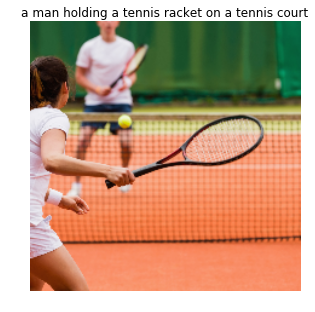

In [35]:
plt.figure(figsize=(12,28))
img = plt.imread('good/tennis-joueurs.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

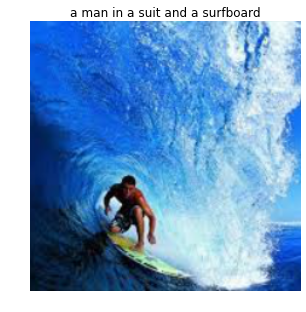

In [43]:
plt.figure(figsize=(12,28))
img = plt.imread('good/images.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

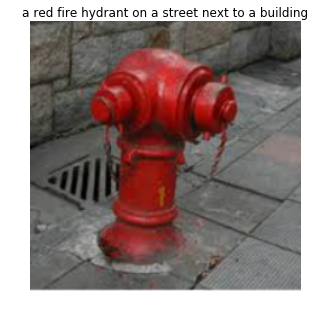

In [60]:
plt.figure(figsize=(12,28))
img = plt.imread('good/q1.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

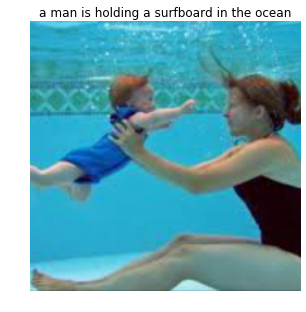

In [68]:
plt.figure(figsize=(12,28))
img = plt.imread('good/q9.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

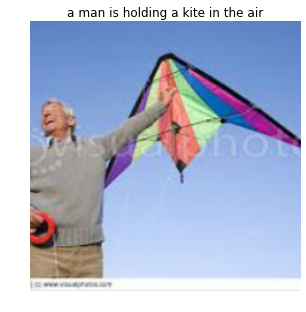

In [69]:
plt.figure(figsize=(12,28))
img = plt.imread('good/w1.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

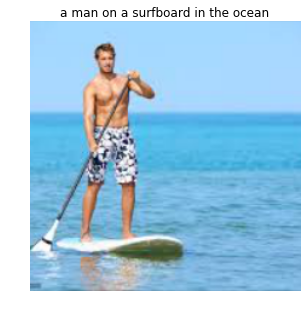

In [72]:
plt.figure(figsize=(12,28))
img = plt.imread('good/w4.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

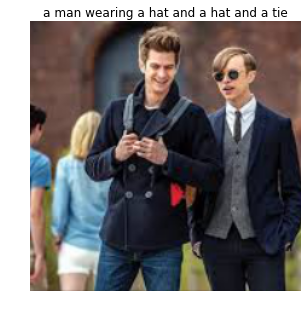

In [73]:
plt.figure(figsize=(12,28))
img = plt.imread('good/w5.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

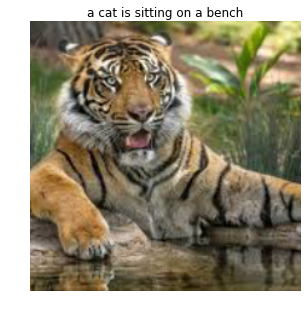

In [79]:
plt.figure(figsize=(12,28))
img = plt.imread('good/e2.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

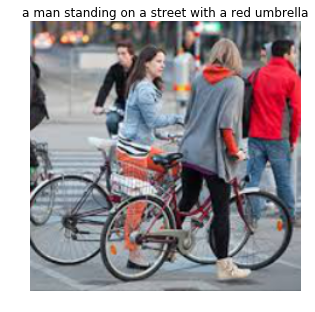

In [82]:
plt.figure(figsize=(12,28))
img = plt.imread('good/e6.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

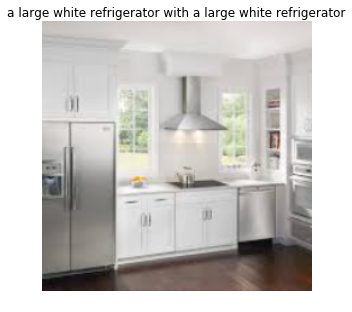

In [84]:
plt.figure(figsize=(12,28))
img = plt.imread('good/e8.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

### Fail examples

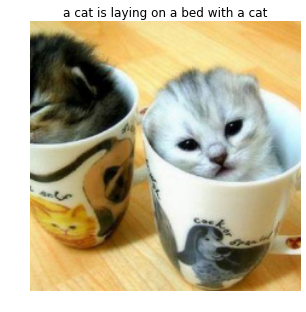

In [34]:
plt.figure(figsize=(12,28))
img = plt.imread('good/tumblr_static_2sqln14f6d44o4sgssc4kccgs_640_v2.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

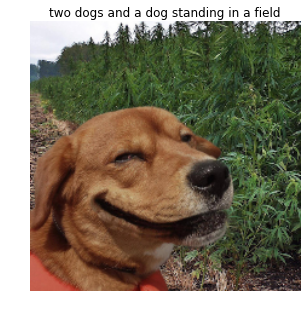

In [37]:
plt.figure(figsize=(12,28))
img = plt.imread('good/rr231.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

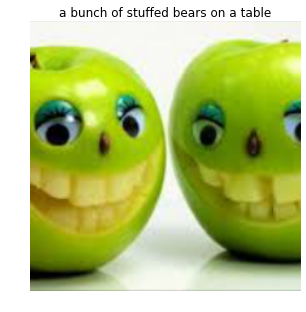

In [40]:
plt.figure(figsize=(12,28))
img = plt.imread('good/jnb.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

Exception KeyboardInterrupt in 'zmq.backend.cython.message.Frame.__dealloc__' ignored


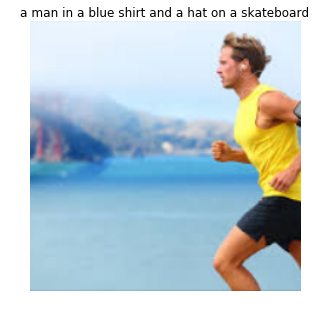

In [42]:
plt.figure(figsize=(12,28))
img = plt.imread('good/jkl.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

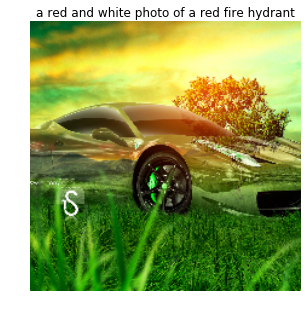

In [45]:
plt.figure(figsize=(12,28))
img = plt.imread('good/Ferrari-458-Italia-Crystal-Nature-Car-2013-HD-Wallpapers-design-by-Tony-Kokhan-www.el-tony.com_.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

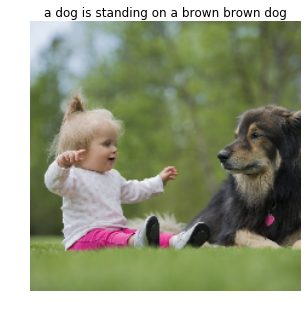

In [47]:
plt.figure(figsize=(12,28))
img = plt.imread('good/fa3d30fc2eb1302ceb0e12d7e4f288c0.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

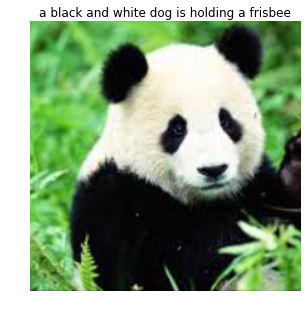

In [50]:
plt.figure(figsize=(12,28))
img = plt.imread('good/erqwer.jpeg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

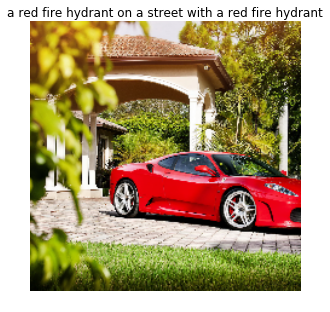

In [53]:
plt.figure(figsize=(12,28))
img = plt.imread('good/car-nature-wallpaper-1.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

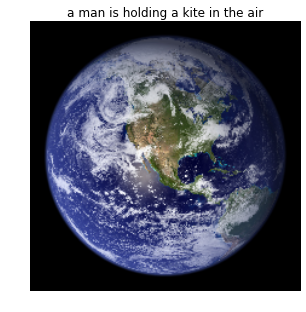

In [55]:
plt.figure(figsize=(12,28))
img = plt.imread('good/bluemarblewest.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

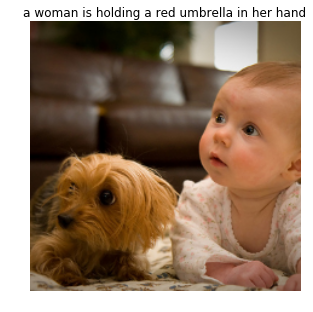

In [57]:
plt.figure(figsize=(12,28))
img = plt.imread('good/3405340751_bbb0b4325b.jpg')
img = preprocess(img)
txt = ' '.join(generate_caption(img,t=5.,sample=False)[1:-1])
plt.subplot(5,2,1)
plt.axis('off')
plt.title(txt)
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

# grading

* base 5 if it compiles and trains without exploding
* +1 for finding representative set of reference examples
* +2 for providing 10+ examples where network provides reasonable captions (at least sometimes :) )
  * you may want to predict with sample=False and deterministic=True for consistent results
  * kudos for submitting network params that reproduce it
* +2 for providing 10+ examples where network fails IF you also got previous 10 examples right


* bonus points for experiments with architecture and initialization (see above)
* bonus points for trying out other pre-trained nets for captioning
* a whole lot of bonus points if you also train via metric learning
 * image -> vec
 * caption -> vec (encoder, not decoder)
 * loss = correct captions must be closer, wrong ones must be farther
 * prediction = choose caption that is closest to image
* a freaking whole lot of points if you also obtain statistically signifficant results the other way round
 * take caption, get closest image